In [5]:
import sys

#sys.path.append('C:/Users/wanglab/Documents/Whisker-Analysis/out/build/MSVC/Release')
sys.path.append('C:/Users/wanglab/Documents/Whisker-Analysis/out/build/Clang/Release')
#sys.path.append('../out/build/MSVC/Release')

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import whiskertracker

# Create an instance of WhiskerTracker
wt = whiskertracker.WhiskerTracker()

wt.setWhiskerPad(582, 267)

img = cv2.imread('C:/Users/wanglab/Desktop/img0011018.png')

if len(img.shape) > 2:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Flatten the image and convert it to a list of uint8_t
image_data = img.flatten().tolist()

wt.trace(image_data,480,640)

In [ ]:
wt.trace(image_data,480,640)
w0 = wt.getWhiskers()

In [7]:
#Clang fast
%timeit wt.trace(image_data,480,640)

493 ms ± 8.07 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
# MSVC slow
%timeit wt.trace(image_data,480,640)

510 ms ± 17.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
# MSVC fast
%timeit wt.trace(image_data,480,640)

(0.0, 480.0)

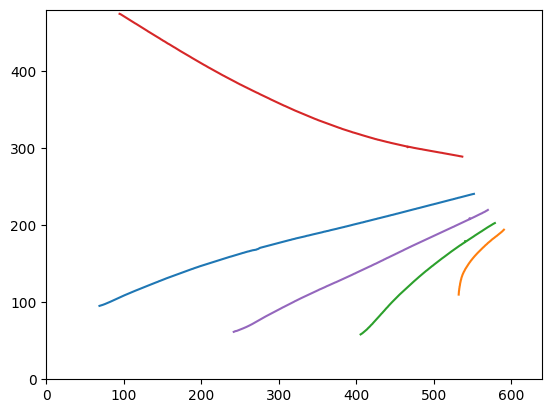

In [37]:
for i in range(0,len(w0)):
    ww = np.reshape(w0[i],(-1,2))
    plt.plot(ww[:,0],ww[:,1])
plt.xlim(0,640)
plt.ylim(0,480)